In [46]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [47]:
device = "cuda"
Epochs = 20
classes = 10

In [48]:
t = transforms.Compose([transforms.ToTensor(),
                       transforms.Lambda(lambda x : x.permute(1, 2, 0).reshape(-1))
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = datasets.SVHN(root="./data", split="train", transform= t, target_transform=target_t, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform= t, target_transform=target_t, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [49]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


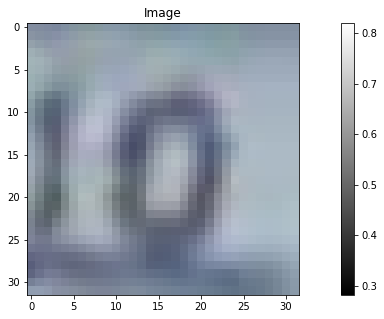

In [50]:
# print(next(iter(test_loader)))
img = next(iter(test_loader))[0][3].reshape(32,32,3)
label = next(iter(test_loader))[1][3]
def visual(img):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(label)

In [51]:
#defining the model 

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 4)
    
    layers = []
    
    in_features = 3 * 32 * 32
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_layer{i}", 256, 1024)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLu())
        
        in_features = out_features
    layers.append(nn.Linear(in_features, classes))
    layers.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*layers)

In [52]:
def objective(trial):
    
    model = Network().to(device)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    
    #training
    for epoch in range(Epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
        #validation
        model.eval()
        total_corr = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                
                data, target = data.to(device), target.type(torch.float32).to(device)
                output = model(data)
                pred = torch.argmax(output, dim=1)
                
                gt = torch.argmax(target, dim=1)
                correct = torch.count_nonzero(pred == gt)
                total_corr += correct
        accuracy = (total_corr/len(test_dataset))
        
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [53]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-13 16:39:29,215] A new study created in memory with name: no-name-50074477-0f8f-4a4b-afb1-2290e43c24e0
[I 2021-11-13 16:43:48,757] Trial 0 finished with value: 0.5062615275382996 and parameters: {'optimizer': 'RMSprop', 'lr': 2.9028529000928725e-05}. Best is trial 0 with value: 0.5062615275382996.
[I 2021-11-13 16:48:05,865] Trial 1 finished with value: 0.6276505589485168 and parameters: {'optimizer': 'Adam', 'lr': 0.0030694612988594948}. Best is trial 1 with value: 0.6276505589485168.
[I 2021-11-13 16:52:22,595] Trial 2 finished with value: 0.1951444298028946 and parameters: {'optimizer': 'SGD', 'lr': 5.438961636729603e-05}. Best is trial 1 with value: 0.6276505589485168.
[I 2021-11-13 16:56:41,104] Trial 3 finished with value: 0.7272971868515015 and parameters: {'optimizer': 'Adam', 'lr': 0.000526320907706507}. Best is trial 3 with value: 0.7272971868515015.
[I 2021-11-13 17:00:56,603] Trial 4 finished with value: 0.5367624163627625 and parameters: {'optimizer': 'Adam', 'l

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  85
  Number of complete trials:  15
Best trial:
  Value:  0.7552627325057983
  Params: 
    optimizer: Adam
    lr: 0.0009683390435270988


In [ ]:
# class Network(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.input_dims = 3072
#         self.layer1 = nn.Linear(in_features=3072, out_features=512)
#         self.layer2 = nn.Linear(in_features=512, out_features=256)
#         self.layer3 = nn.Linear(in_features=256, out_features=64)
#         self.layer4 = nn.Linear(in_features=64, out_features=10)
        
#         self.relu1 = nn.ReLU(inplace=True)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.relu3 = nn.ReLU(inplace=True)
    
#     def forward(self, x):
#         x = self.relu1(self.layer1(x))
#         x = self.relu2(self.layer2(x))
#         x = self.relu3(self.layer3(x))
#         x = self.layer4(x)
#         pred = F.log_softmax(x, dim=1)
#         return x

# model = Network()
# model.to(device)
# criterion = nn.CrossEntropyLoss().to(device)

# lr = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# def training(Epochs=20):
#     loss_list= []
#     loss_hist  = []
#     for epoch in range(Epochs):
#         cur_loss_list = []
#         progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
#         for i, (img, label) in progress_bar:
#             img, label = img.to(device), label.type(torch.float32).to(device)

#             pred = model.forward(img)

#             loss = criterion(pred, label)
#             cur_loss_list.append(loss.item())
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             if(i % 1 == 0):
#                 progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
#         loss_list = loss_list + cur_loss_list        
#         loss_hist.append(np.mean(cur_loss_list))
#     return loss_list, loss_hist
# training()

# def testing(test_loader, net):
#     with torch.no_grad():
#         total_corr = 0
#         for x, y in test_loader:
# #             x, y = x.to(device), y.type(torch.float32).to(device)

#             output = net.forward(x)

#             pred = torch.argmax(torch.Tensor(output), dim=1)
#             gt = torch.argmax(y, dim=1)
#             correct = torch.count_nonzero(pred == gt)
#             total_corr += correct
#         return (total_corr/len(test_dataset))

# testing(test_loader, model.to("cpu"))